In [1]:
import pandas as pd
import xml.etree.ElementTree as et
import re,time
from bs4 import BeautifulSoup
import sqlite3
import numpy as np
import pygtrie
from matplotlib import pyplot as plt
from py2neo import Graph, Node, Relationship

In [2]:
def getColumns(xml_str):
    return [re.sub(r"[\n\t\s]*", "", part) for part in xml_str.split('-')]

In [3]:
user_cols = getColumns('''Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes''')
post_cols = getColumns('''Id
       - PostTypeId
       - ParentId
       - AcceptedAnswerId
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName
       - LastEditDate
       - LastActivityDate
       - CommunityOwnedDate
       - ClosedDate
       - Title
       - Tags
       - AnswerCount
       - CommentCount
       - FavoriteCount''')
comment_cols= getColumns('''Id
       - PostId
       - Score
       - Text
       - CreationDate
       - UserId''')
badges_cols = getColumns('''UserId
       - Name
       - Date''')
posthistory_cols = getColumns('''Id
- PostHistoryTypeId
- PostId
- RevisionGUID
- CreationDate
- UserId
- UserDisplayName
- Comment
    - Text
- CloseReasonId''')
postlinks_cols = getColumns('''Id
     - CreationDate
     - PostId
     - RelatedPostId
     - LinkTypeId''')
votes_cols = getColumns('''Id
     - PostId
     - VoteTypeId
     - CreationDate
     - UserId
     - BountyAmount''')
tags_cols = ['TagName','Count','ExcerptPostId','WikiPostId']

In [4]:
def getDataFrame(file, cols, html_clean_cols):
    xtree = et.parse(file)
    root = xtree.getroot()
    rows = []
    html_clean_cols = set(html_clean_cols)
    for node in root:
        row = []
        for col in cols:
            if node is not None and node.attrib.get(col) is not None: 
                if col in html_clean_cols:
                    row.append(BeautifulSoup(node.attrib.get(col)).get_text())
                else:
                    row.append(node.attrib.get(col))
            else:
                row.append(None)
        rows.append({col: row[i] for i, col in enumerate(cols)})
    return pd.DataFrame(rows, columns=cols)

In [5]:
df_user = getDataFrame('Users.xml',user_cols,['AboutMe'])
df_post = getDataFrame('Posts.xml',post_cols,[])
df_comment = getDataFrame('Comments.xml', comment_cols,[])
df_badges = getDataFrame('Badges.xml', badges_cols, [])
df_post_history = getDataFrame('PostHistory.xml', posthistory_cols, [])
df_tags = getDataFrame('Tags.xml', tags_cols, [])
df_post_links = getDataFrame('PostLinks.xml', postlinks_cols, [])
df_votes = getDataFrame('Votes.xml', votes_cols, [])


C:\Users\Rajnish\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rajnish\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [6]:
df_user.columns
df_post.Score = pd.to_numeric(df_post.Score, errors='coerce').fillna(0).astype(np.int64)
df_comment.Score = pd.to_numeric(df_comment.Score, errors='coerce').fillna(0).astype(np.int64)
df_post['CreationDate'] = pd.to_datetime(df_post['CreationDate'])
df_votes['CreationDate'] = pd.to_datetime(df_votes['CreationDate'])
df_post_links['CreationDate'] = pd.to_datetime(df_post_links['CreationDate'])
df_post['ViewCount'] = pd.to_numeric(df_post['ViewCount'])
df_votes['CreationDate'] = pd.to_datetime(df_votes['CreationDate'])

In [7]:

tag_map = []
trie = pygtrie.CharTrie()
for i, row in df_post.iterrows():
    if row['PostTypeId'] == '2':
        continue
    if row['Tags'] is None:
        continue
    tags = row['Tags'].split('<')
    tags = tags[1:]
    for tag in tags:
        if tag[:-1] in trie:
            trie[tag[:-1]].add(row['Id'])
        else:
            trie[tag[:-1]] = set([row['Id']])
        if tag[:-1] in df_tags['TagName'].values:
            tag_map.append({'Id': row['Id'], 'tagId': tag[:-1]})
df_tag_map = pd.DataFrame(tag_map, columns=['Id','tagId'])


In [8]:
con = sqlite3.connect('test.db')
cur = con.cursor()


In [9]:
pp = 0
if pp == 1:
    df_user.to_csv(index=False)
    df_post.to_csv(index=False)
    df_comment.to_csv(index=False)
    df_badges.to_csv(index=False)
    df_post_history.to_csv(index=False)
    df_tags.to_csv(index=False)
    df_post_links.to_csv(index=False)
    df_votes.to_csv(index=False)
    df_tag_map.to_csv(index=False)
#     df_tag_map.to_sql(name='tag_map', if_exists='replace', con=con)
#     df_user.to_sql(name='user', if_exists='replace', con=con)
#     df_post.to_sql(name='post', if_exists='replace',con=con)
#     df_comment.to_sql(name='comment', if_exists='replace',con=con)
#     df_badges.to_sql(name='badges', if_exists='replace',con=con)
#     df_post_history.to_sql(name='post_history', if_exists='replace',con=con)
#     df_tags.to_sql(name='tags', if_exists='replace',con=con)
#     df_post_links.to_sql(name='post_links',if_exists='replace', con=con)
#     df_votes.to_sql(name='votes', if_exists='replace',con=con)

In [10]:
df_post.columns
post_cols
# df_votes.to_sql(name='votes', if_exists='replace',con=con)
df_post.to_sql(name='post',if_exists='replace',con=con)

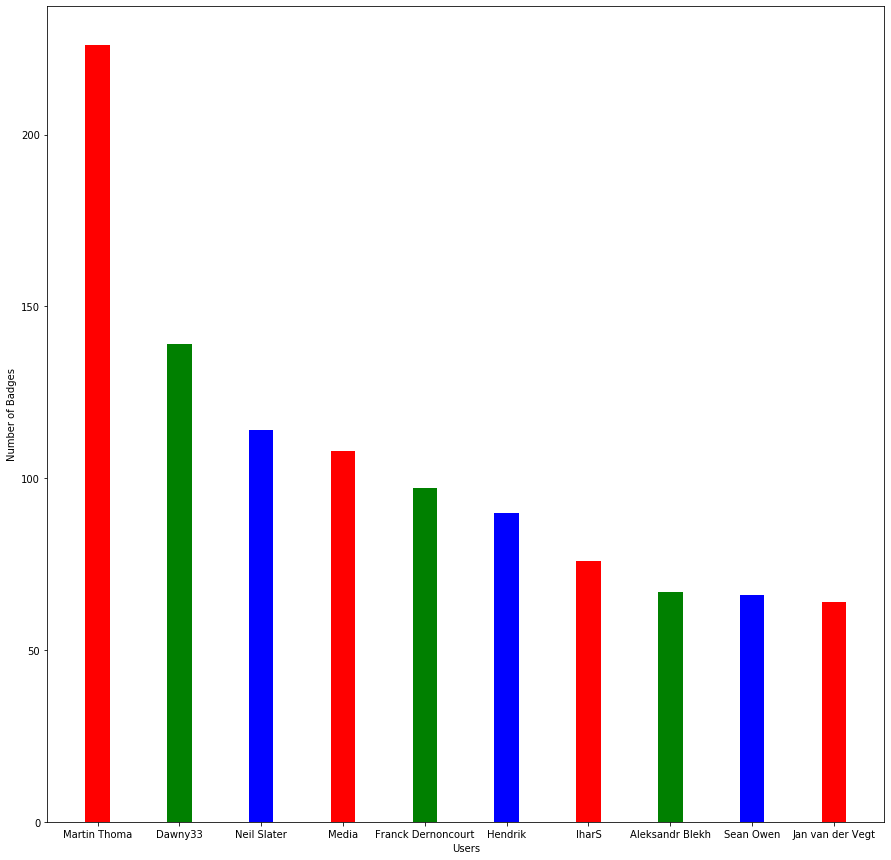

In [12]:
plt.rcParams['figure.figsize'] = [15,15]
cur.execute('''select count(UserID) as No_of_badges, UserID  from badges group by UserId order by No_of_badges desc limit 10;''')
rows = cur.fetchall()
col=['No_of_badges','UserId']
df_bad=pd.DataFrame(rows,columns=col)
df_new=pd.merge(df_bad, df_user, left_on='UserId', right_on='Id')
fig = plt.figure()
ax = plt.subplot(111)
w = 0.3
ax.bar(df_new['DisplayName'], df_new['No_of_badges'], width=w, color='rgb', align='center')
ax.autoscale(tight=False)
plt.xticks(rotation=0)
plt.ylabel("Number of Badges")
plt.xlabel("Users")
plt.show()
fig.savefig('Most active users.png')



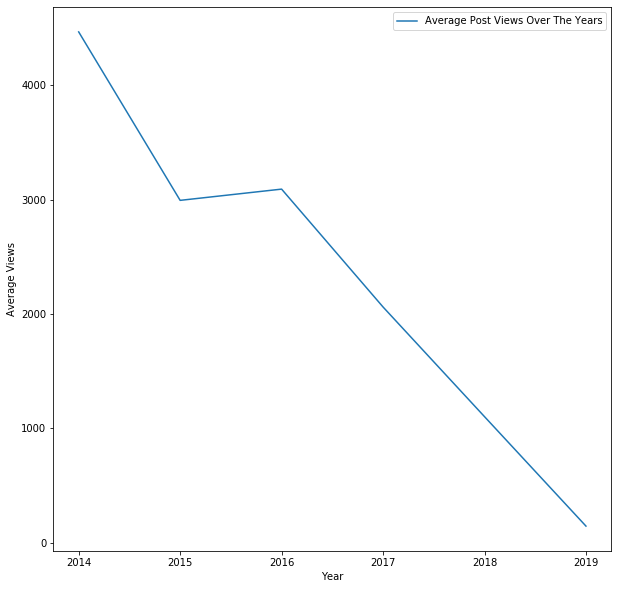

In [13]:

plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select avg(ViewCount) as avgViewCount,(select strftime('%Y', CreationDate)) as year from post group by year order by year asc;''')
rows = cur.fetchall()
col=['avgViewCount','year']
df_viewcount=pd.DataFrame(rows,columns=col)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_viewcount['year'], df_viewcount['avgViewCount'], label='Average Post Views Over The Years')
ax1.legend(loc=1)

plt.ylabel("Average Views")
plt.xlabel("Year")
plt.show()
fig.savefig('Average_views.png')

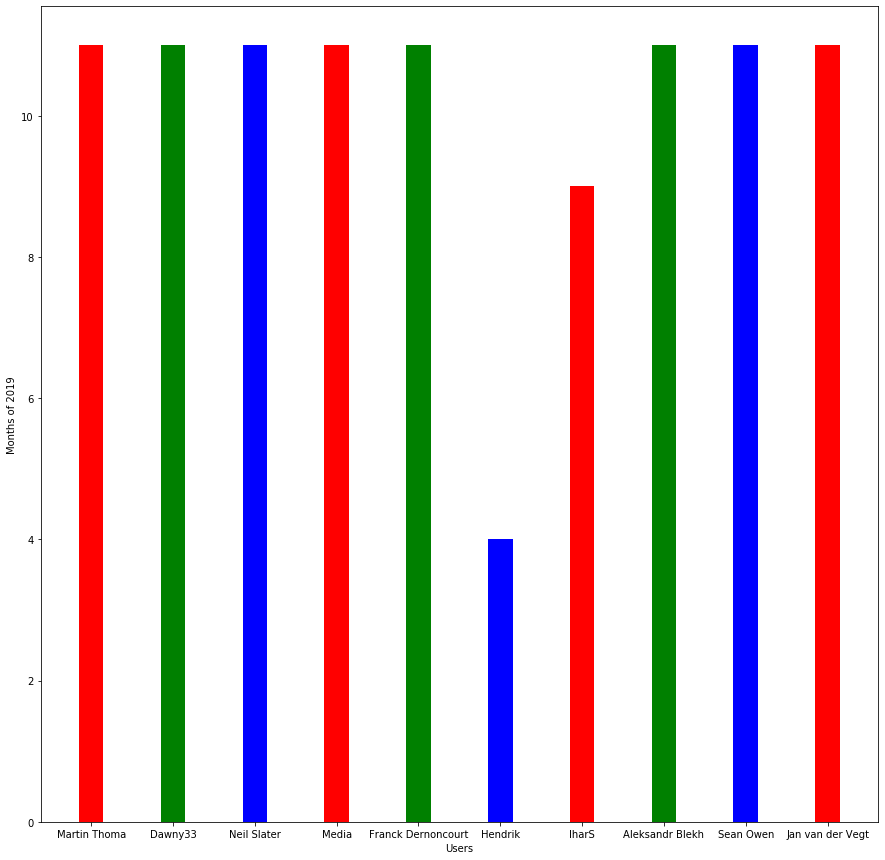

In [189]:
plt.rcParams['figure.figsize'] = [15,15]
df_new['LastAccessDate'] = pd.to_datetime(df_new['LastAccessDate'])
fig = plt.figure()
ax = plt.subplot(111)
w = 0.3
ax.bar(df_new['DisplayName'], df_new['LastAccessDate'].dt.month, width=w, color='rgb', align='center')
ax.autoscale(tight=False)
plt.xticks(rotation=0)
plt.ylabel("Months of 2019")
plt.xlabel("Users")
plt.show()
fig.savefig('Consistency.png')

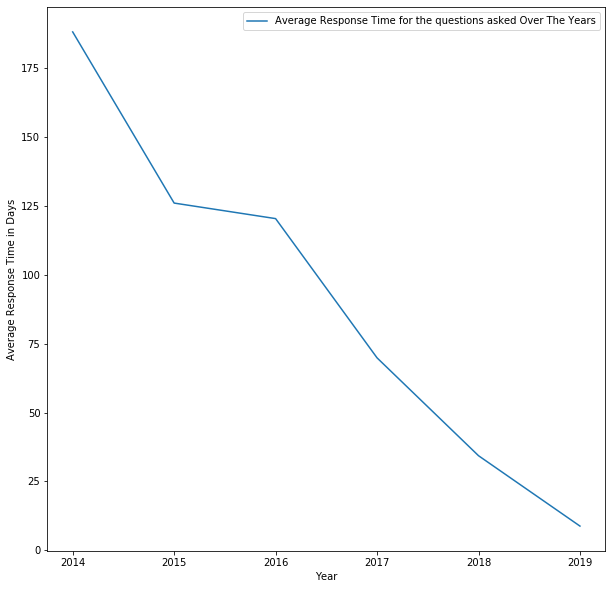

Wall time: 5.45 s


In [190]:
%%time
plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''Select  avg(CAST((julianday(b.CreationDate) - julianday(a.CreationDate)) AS real)),strftime('%Y', a.CreationDate) from post a, post b where  a.PostTypeId= 1 and b.PostTypeId = 2 and a.Id = b.ParentId group by strftime('%Y', a.CreationDate);''')
rows = cur.fetchall()
col=['avgResponseTime','Year']
df_responsetime=pd.DataFrame(rows,columns=col)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_responsetime['Year'], df_responsetime['avgResponseTime'], label='Average Response Time for the questions asked Over The Years')
ax1.legend(loc=1)

plt.ylabel("Average Response Time in Days")
plt.xlabel("Year")
plt.show()
fig.savefig('Average_Response_time.png')

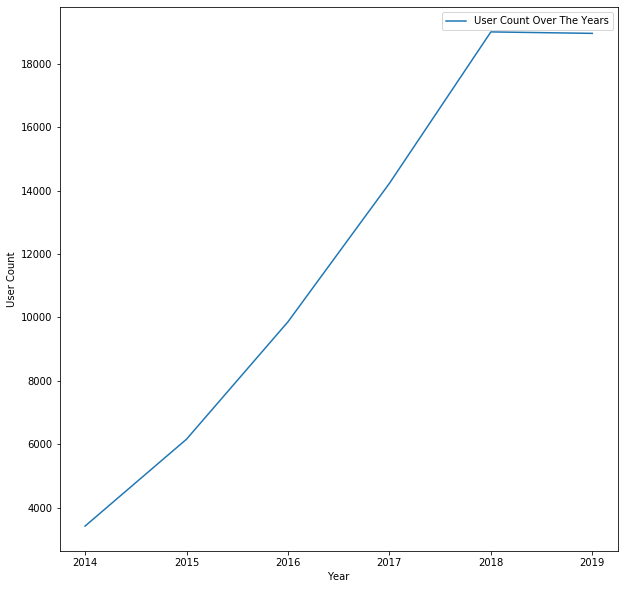

In [16]:
plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select count(Id), strftime('%Y', CreationDate) from user group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['UserCount','Year']
df_usercount=pd.DataFrame(rows,columns=col)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_usercount['Year'], df_usercount['UserCount'], label='User Count Over The Years')
ax1.legend(loc=1)

plt.ylabel("User Count")
plt.xlabel("Year")
plt.show()
fig.savefig('UserCount.png')

In [17]:
df_trial=pd.DataFrame(trie['java'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_java=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_java.to_sql(name='javaresponse',if_exists='replace',con=con)


df_trial=pd.DataFrame(trie['python'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_python=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_python.to_sql(name='pythonresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['r'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_r=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_r.to_sql(name='rresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['scala'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_scala=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_scala.to_sql(name='scalaresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['c'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_c=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_c.to_sql(name='cresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['javascript'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_javascript=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_javascript.to_sql(name='javascriptresponse',if_exists='replace',con=con)

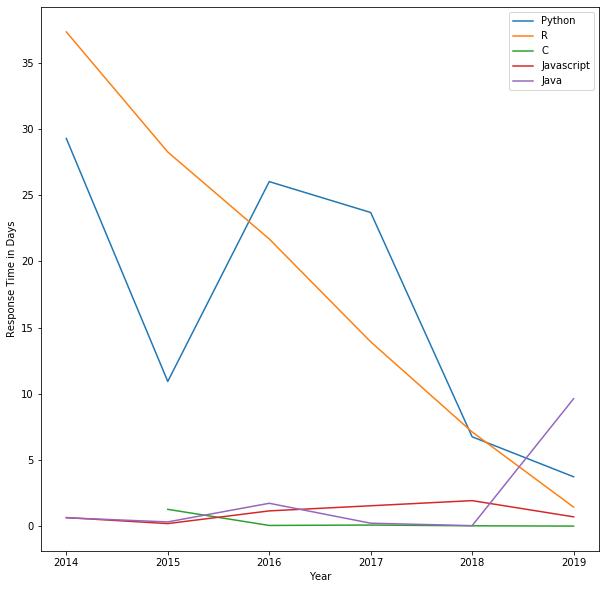

In [191]:
plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from pythonresponse group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_python=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from cresponse group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_c=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from rresponse group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_r=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from scalaresponse group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_scala=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from javascriptresponse group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_javascript=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from javaresponse group by strftime('%Y', CreationDate);''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_java=pd.DataFrame(rows,columns=col)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_python['Year'], df_python['ResponseTime'], label='Python')
ax1.plot(df_r['Year'], df_r['ResponseTime'], label='R')
#ax1.plot(df_scala['Year'], df_scala['ResponseTime'], label='Scala')
ax1.plot(df_c['Year'], df_c['ResponseTime'], label='C')
ax1.plot(df_javascript['Year'], df_javascript['ResponseTime'], label='Javascript')
ax1.plot(df_java['Year'], df_java['ResponseTime'], label='Java')
ax1.legend(loc=1)

plt.ylabel("Response Time in Days")
plt.xlabel("Year")
plt.show()
fig.savefig('ResponseTimeLanguage.png')

In [19]:
%%time
df_trial=pd.DataFrame(trie['keras'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_keras=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_keras.to_sql(name='kerasresponse',if_exists='replace',con=con)


df_trial=pd.DataFrame(trie['scikit-learn'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_scikit=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_scikit.to_sql(name='scikitresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['nltk'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_nltk=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_nltk.to_sql(name='nltkresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['pytorch'].union(trie['torch']))
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_torch=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_torch.to_sql(name='torchresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['scipy'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_scipy=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_scipy.to_sql(name='scipyresponse',if_exists='replace',con=con)

df_trial=pd.DataFrame(trie['tensorflow'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_tensorflow=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_tensorflow.to_sql(name='tensorflowresponse',if_exists='replace',con=con)

Wall time: 434 ms


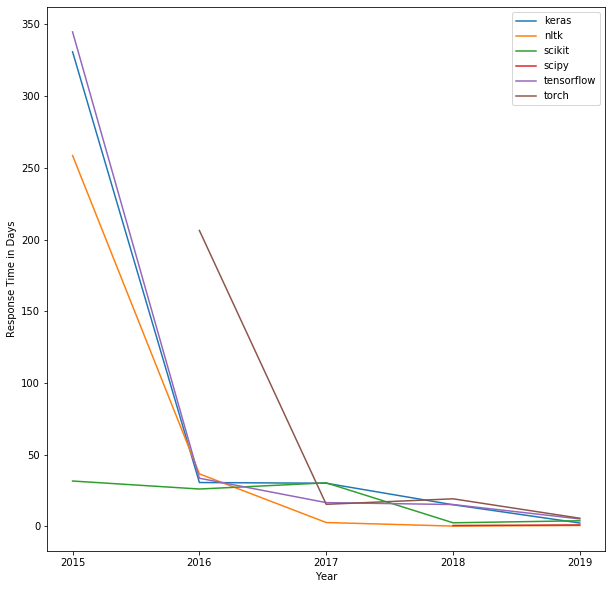

Wall time: 1.46 s


In [204]:
%%time
plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from kerasresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_keras=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from nltkresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_nltk=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from torchresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_torch=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from scipyresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_scipy=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from tensorflowresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_tensorflow=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from scikitresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_scikit=pd.DataFrame(rows,columns=col)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_keras['Year'], df_keras['ResponseTime'], label='keras')
ax1.plot(df_nltk['Year'], df_nltk['ResponseTime'], label='nltk')
df_scikit=df_scikit[df_scikit.Year!='2014']
ax1.plot(df_scikit['Year'], df_scikit['ResponseTime'], label='scikit')
ax1.plot(df_scipy['Year'], df_scipy['ResponseTime'], label='scipy')
ax1.plot(df_tensorflow['Year'], df_tensorflow['ResponseTime'], label='tensorflow')
ax1.plot(df_torch['Year'], df_torch['ResponseTime'], label='torch')
ax1.legend(loc=1)

plt.ylabel("Response Time in Days")
plt.xlabel("Year")
plt.show()
fig.savefig('ResponseTimeLibrary.png')

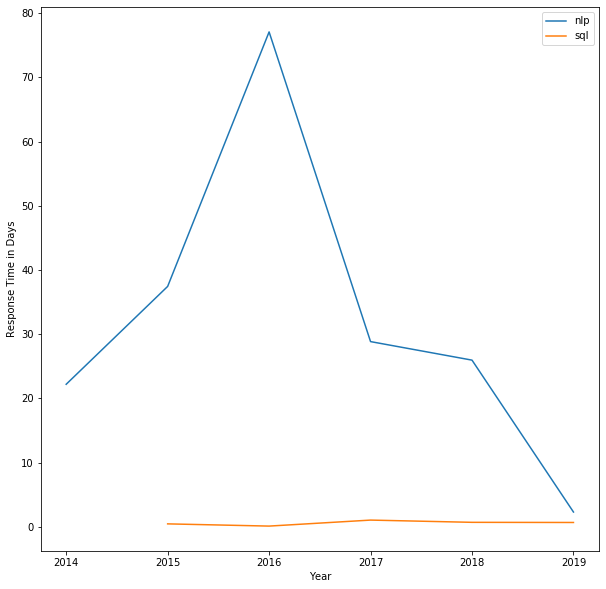

In [193]:
df_trial=pd.DataFrame(trie['nlp'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_nlp=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_nlp.to_sql(name='nlpresponse',if_exists='replace',con=con)


df_trial=pd.DataFrame(trie['sql'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_sql=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_sql.to_sql(name='sqlresponse',if_exists='replace',con=con)

plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from nlpresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_nlp=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from sqlresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_sql=pd.DataFrame(rows,columns=col)


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_nlp['Year'], df_nlp['ResponseTime'], label='nlp')
ax1.plot(df_sql['Year'], df_sql['ResponseTime'], label='sql')

ax1.legend(loc=1)

plt.ylabel("Response Time in Days")
plt.xlabel("Year")
plt.show()
fig.savefig('ResponseTimenlpvssql.png')

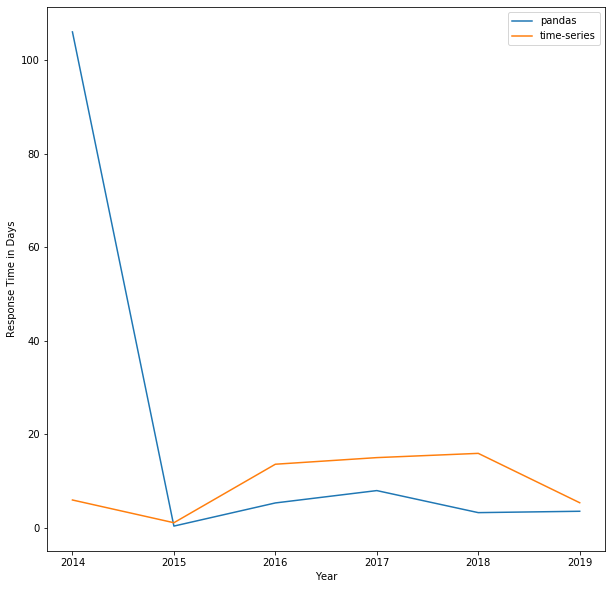

Wall time: 1.13 s


In [194]:
%%time
df_trial=pd.DataFrame(trie['pandas'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_pandas=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_pandas.to_sql(name='pandasresponse',if_exists='replace',con=con)


df_trial=pd.DataFrame(trie['time-series'])
df_trial=df_trial.rename(columns={0:'Id'})
df_trial=pd.merge(df_trial, df_post, left_on='Id', right_on='Id')
df_trial=df_trial[df_trial['AcceptedAnswerId'].notnull()]
df_trial1=pd.merge(df_trial['AcceptedAnswerId'], df_post[['CreationDate','Id']], left_on='AcceptedAnswerId', right_on='Id')
df_trial1=df_trial1.rename(columns={'CreationDate':'CreationDateResponse'})
df_timeseries=pd.merge(df_trial[['AcceptedAnswerId','CreationDate','Id']], df_trial1[['CreationDateResponse','AcceptedAnswerId']], left_on='AcceptedAnswerId', right_on='AcceptedAnswerId')
pp=0
if pp==1:
    df_timeseries.to_sql(name='timeseriesresponse',if_exists='replace',con=con)

plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from pandasresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_pandas=pd.DataFrame(rows,columns=col)
cur.execute('''select avg(CAST((julianday(CreationDateResponse) - julianday(CreationDate)) AS real)),strftime('%Y', CreationDate) from timeseriesresponse group by strftime('%Y', CreationDate)order by strftime('%Y', CreationDate) asc;''')
rows = cur.fetchall()
col=['ResponseTime','Year']
df_timeseries=pd.DataFrame(rows,columns=col)



fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_pandas['Year'], df_pandas['ResponseTime'], label='pandas')
ax1.plot(df_timeseries['Year'], df_timeseries['ResponseTime'], label='time-series')

ax1.legend(loc=1)

plt.ylabel("Response Time in Days")
plt.xlabel("Year")
plt.show()
fig.savefig('ResponseTimepandasvstimeseries.png')

In [23]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [24]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df_post['Body'])]

In [207]:
%%time
max_epochs = 20
vec_size = 300
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1,workers=8)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0


C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Model Saved
Wall time: 13min 17s


In [137]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
df_post['Title'].dropna(inplace=True)
test_data = [word_tokenize(str(row.Title).lower()) for i, row in enumerate(df_post.itertuples(), 1)]


In [138]:
v1=[]

for i in test_data:
    v1.append((model.infer_vector(i)).mean())

In [139]:
df_list=pd.DataFrame(v1)


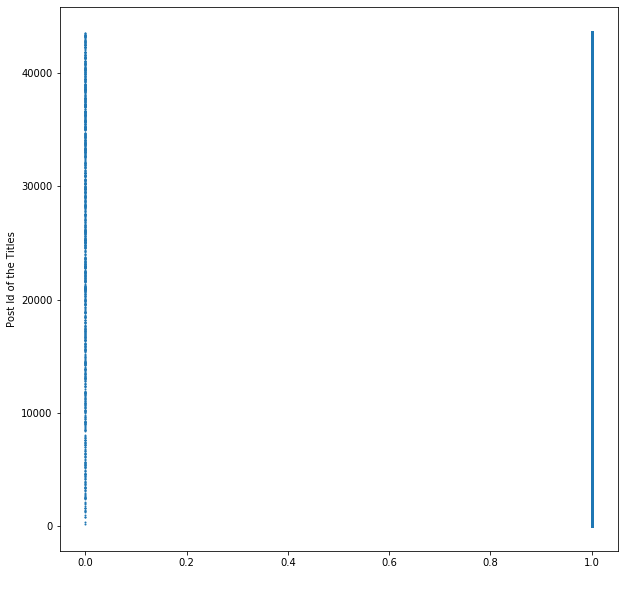

In [208]:
fig = plt.figure()
plt.scatter(df_list>-.01, range(0,43650),s=1)
plt.ylabel("Post Id of the Titles")
plt.xlabel(" ")
plt.show()
fig.savefig('model_doc2vec_1.png')

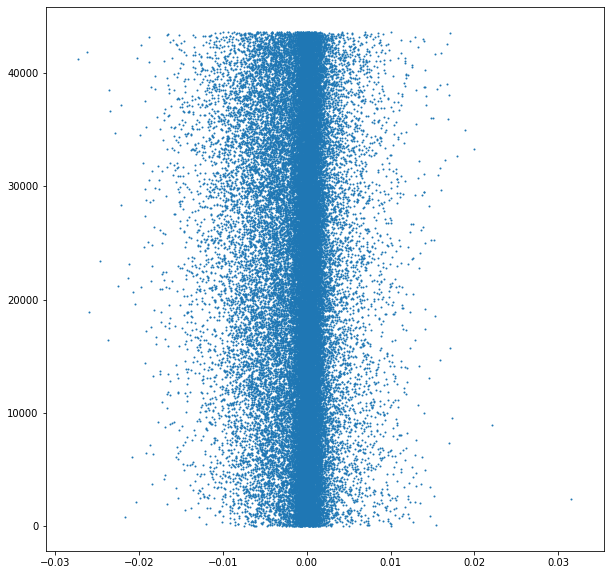

In [173]:
fig = plt.figure()
plt.scatter(df_list, range(0,43650),s=1)
plt.show()
fig.savefig('model_doc2vec_2.png')